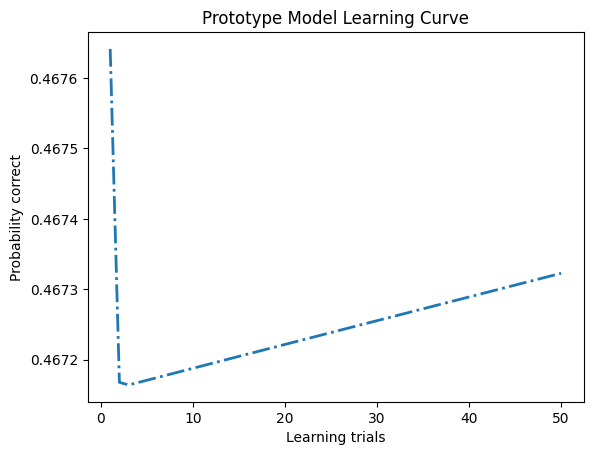

Final Classification Result: 0.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset function
def load_data():
    file_path = "Gender & Pronouns survey (Responses) - Form Responses 1.csv"
    data = pd.read_csv(file_path)

    # Select relevant columns
    input_columns = [
        "Based on your Physical Appearance, select one that best identifies you",
        "What is your Dressing Style?",
        "How do you identify yourself (Self-Identification)?"
    ]
    target_columns = ["What is your Gender Category?", "What is your Pronoun(s)?"]

    # Drop rows with missing values in essential columns
    data_cleaned = data[input_columns + target_columns].dropna()

    # Encode categorical text data into numerical values
    label_encoders = {}
    for col in input_columns + target_columns:
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le  # Store encoders for future use

    # Normalize input data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data_cleaned[input_columns].values)  # Normalize to range [0, 1]
    Y = data_cleaned[target_columns].values  # Last 2 columns as output
    return X, Y

# Compute input and output activations
def inout(I1, I2, X, W, sig, st):
    in1 = 1.0 / np.exp(((I1 - X[st, 0]) / sig) ** 2)
    in1 = in1 / np.sum(in1)  # Normalize
    in2 = 1.0 / np.exp(((I2 - X[st, 1]) / sig) ** 2)
    in2 = in2 / np.sum(in2)  # Normalize
    In = np.concatenate((in1, in2))
    In = In.reshape((-1, 1))
    Out = W @ In  # Compute output activations
    return In, Out

# Prototype model function
def prototype(alf, b, sig, X, Y, nr, cutoff):
    ns = X.shape[0]  # Number of stimuli
    Max = int(np.max(X))
    I1 = np.arange(Max + 1)
    I2 = np.arange(Max + 1)
    
    W = np.zeros((2, (Max + 1) * 2))  # Weight matrix for 2 categories
    T = np.zeros((nr, 4))
    mT = np.zeros(nr)
    
    for rep in range(nr):
        protoA = np.mean(X, axis=0)
        protoB = np.mean(Y, axis=0)
        
        for st in range(ns):
            In, Out = inout(I1, I2, X, W, sig, st)
            WA = alf * (np.array([1, 0])[:, None] - Out) @ In.T
            W += WA
            
            In, Out = inout(I1, I2, Y, W, sig, st)
            WB = alf * (np.array([0, 1])[:, None] - Out) @ In.T
            W += WB
        
        for st in range(4):
            _, Out = inout(I1, I2, X, W, sig, st)
            p = np.exp(b * Out)
            p = p[0] / np.sum(p)
            T[rep, st] = p.item()
        
        mT[rep] = ((T[rep, 1] - T[rep, 0]) > cutoff) and ((T[rep, 2] - T[rep, 3]) > cutoff)
    
    return mT, T

# Main program
def main():
    X, Y = load_data()
    
    nr = 50
    alf = 0.1
    b = 2.5
    sig = 5
    cutoff = 0.2
    
    mT, T = prototype(alf, b, sig, X, Y, nr, cutoff)
    
    plt.figure()
    plt.plot(range(1, nr + 1), (T[:, 1] + T[:, 2]) / 2, '-.', linewidth=2)
    plt.xlabel('Learning trials')
    plt.ylabel('Probability correct')
    plt.title('Prototype Model Learning Curve')
    plt.show()
    
    print('Final Classification Result:', mT[-1])

if __name__ == "__main__":
    main()
